In [2]:
import pandas
import pandas as pd
import numpy as np
import sys
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tqdm import tqdm

deepctr_path = '/root/linghui/rec-fairness/'
sys.path.append(deepctr_path)
import deepctr
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, get_feature_names

2022-07-14 16:06:41.029593: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [7]:
def get_feat_dict(data):
    if data == 'ml-1m':
        feat_dict = {'item_id': 3706,
                 'user_id': 6040,
                 'gender': 2,
                 'age': 7,
                 'occupation': 21,
                 'zipcode': 3439}
    if data == 'black-fri':
        feat_dict = {'user_id': 5891,
                 'item_id': 3631,
                 'gender': 2,
                 'age': 7,
                 'occupation': 21,
                 'city': 3,
                 'stay_years': 5,
                 'martial_status': 2,
                 'cate': 20,
                 'subcate_1': 18,
                 'subcate_2': 16,
                 'price': 23962}
    return feat_dict

def get_saved_model_details(model_params, data_params):
    model_name = model_params['model_name']
    cate = model_params['cate']
    dataset = data_params['dataset']
    if dataset == 'ml-1m':
        if model_name == 'DeepFM':
            # if cate == 'all-feat':
            #     check_path = '/data/linghui/saved_model/deepfm-ml-1m/deepfm-all-feature/deepfm-ml-1m.ckpt'
            #     train_feats = ["item_id", "user_id", "gender", "age", "occupation", "zipcode"]
            # if cate == 'del-sf':
            #     check_path = '/data/linghui/saved_model/deepfm-ml-1m/deepfm-del-sf/deepfm-ml-1m-del-sf.ckpt'
            #     train_feats = ["item_id", "user_id"]
            if cate == 'liuyi-all-feats':
                check_path = '/data/linghui/saved_model/deepfm-ml-1m/deepfm-liuyi/deepfm-ml-1m-liuyi.ckpt'
                train_feats = ["item_id", "user_id", "gender", "age", "occupation", "zipcode"]
    if dataset == 'black-fri':
        if model_name == 'DeepFM':
            if cate == 'liuyi-all-feats':
                check_path = '/data/linghui/saved_model/deepfm-black-fri/deepfm-black-fri-liuyi.ckpt'
                train_feats = ['user_id','item_id','gender','age','occupation','city','stay_years','martial_status','cate','subcate_1','subcate_2','price']
    return check_path , train_feats

def get_model(model_params,data_params):
    dataset = data_params['dataset']

    model_name = model_params['model_name']
    cate = model_params['cate']
    embedding_dim = model_params['embedding_dim']
    check_path, train_feats = get_saved_model_details(model_params,data_params)
    
    feat_dict = get_feat_dict(dataset)
    fixlen_feature_columns = [SparseFeat(feat, feat_dict[feat], embedding_dim=embedding_dim)
                                      for feat in train_feats]
    linear_feature_columns = fixlen_feature_columns 
    dnn_feature_columns = fixlen_feature_columns 
    feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
    

    if model_name == 'DeepFM':
        model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
    model.summary()
    model.load_weights(check_path)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',
                  metrics=['AUC', 'Precision', 'Recall'])
    return model


def create_single_rule(key,value):
    return{key:value}

def get_single_sparse_rule(df,features):
    single_rule = []
    feat_value = df[features].value_counts()
    feat_value = feat_value.index
    sparse_feat_value = feat_value.values.astype('int32')
    for value in sparse_feat_value:
        rule = create_single_rule(features,value)
        single_rule.append(rule)
    return single_rule

def get_single_dense_rule(df,feature,k):
    min_value = df[feature].min()
    max_value = df[feature].max()
    single_rule = []
    d = math.ceil((max_value - min_value) / k)
    for i in range(k):
        x = min_value + i * d
        y = x + d
        single_rule.append({feature:[x,y]})
    return single_rule

def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

def combine_rule(rule_dict_1,rule_dict_2):
    len1 = len(rule_dict_1)
    len2 = len(rule_dict_2)
    all_rule = []
    for i in range(len1):
        rule1 = rule_dict_1[i]
        for j in range(len2):
            rule2 = rule_dict_2[j]
            merge_rule = merge_two_dicts(rule1,rule2)
            all_rule.append(merge_rule)
    return all_rule

def creat_sparse_rule_query(rule):
    result = ''
    key = rule.keys()
    length = len(key)
    count = 0
    for i in key:
        count = count + 1
        result = result + '( ' + i +' == ' + str(rule[i]) + ')'
        # elif i[0] == 'I':
        #     result = result + '(' + str(rule[i][0]) + ' <= ' + i + ' <= ' +  str(rule[i][1]) + ')'
        if count < length:
            result = result + ' & '
    return result

def get_all_rule_dict(data,sparse_feats,dense_feats,dense_num):
    single_rule_dict = []
    all_rule_dict = []
    if len(sparse_feats) > 0:
        for feature in sparse_feats:
            temp_rule = []
            single_rule = get_single_sparse_rule(data,feature)  
            single_rule_dict = single_rule_dict + single_rule
            if len(all_rule_dict) > 0: 
                temp_rule = combine_rule(all_rule_dict,single_rule)
            all_rule_dict = all_rule_dict + single_rule + temp_rule
    if len(dense_feats) > 0:
        for feature in dense_feats:
            temp_rule = []
            single_rule = get_single_dense_rule(data,feature,dense_num)  
            single_rule_dict = single_rule_dict + single_rule
            if len(all_rule_dict) > 0: 
                temp_rule = combine_rule(all_rule_dict,single_rule)
            all_rule_dict = all_rule_dict + single_rule + temp_rule 
    return all_rule_dict

def get_evaluate_data(data,rule):
    result = creat_sparse_rule_query(rule)
    select_group = data.query(result)
    unselect_group = data.drop(select_group.index)

    return select_group,unselect_group

def cut_rule(length_all,length_group,theta):
    x = length_group / length_all
    if (x >= theta) & (x < 1-theta):
        return 1
    else:
        return 0

def get_test_data(x_file,y_file):
    test_x = np.loadtxt(x_file)
    test_y = np.loadtxt(y_file)

    sparse_features = ['C' + str(i) for i in range(1, 27)]
    dense_features = ['I' + str(i) for i in range(1, 14)]
    features = sparse_features + dense_features

    test_x = pd.DataFrame(test_x,columns=features)
    test_y = pd.DataFrame(test_y,columns=['label'])

    test = pd.concat([test_x, test_y], axis=1)
    return test

In [4]:
def create_ml_test_data(model_params,data_params):
    #load test data
    saved_data_path = '/data/linghui/ml-1m/processed_data/'
    test_data_path = saved_data_path + 'test_data_liuyi.csv'
    test_data = pd.read_csv(test_data_path,index_col=0)
    
    #get model info
    check_path ,train_features = get_saved_model_details(model_params, data_params)
    model = get_model(model_params,data_params)
    
    #get predict values
    test_input = {name: test_data[name].values for name in train_features}
    label = test_data['label'].values
    y_true = label
    y_pred = model.predict(test_input)

    test_data['predict'] = y_pred
    cate_list = [eval(s) for s in test_data['cate']]
    test_data['cate'] = cate_list
    return test_data

In [5]:
# model_name: DeepFM / 
# cate : all-feat / del-sf

model_params = {'model_name': 'DeepFM',
                'cate': 'liuyi-all-feats',
                'embedding_dim': 4,
                'batch_size': 256 }

data_params = {'dataset': 'ml-1m'}

test_data = create_ml_test_data(model_params,data_params)

2022-07-14 16:08:58.515757: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-07-14 16:08:58.529894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 16:08:58.531236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:dc:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-07-14 16:08:58.531333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 16:08:58.532614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID:

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
gender (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
age (InputLayer)                [(None, 1)]          0                                            
_______________________________________________________________________________________

2022-07-14 16:09:01.553761: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [6]:
test_data

,user_id,item_id,label,timestamp,gender,age,occupation,zipcode,cate,popularity,predict
0,0,47,1,978824351,0,0,10,1588,"[1, 2, 15, 6]",0.038122,0.939831
1,1,1737,1,978300174,1,6,16,2248,[13],0.111349,0.823337
2,2,1900,1,978298504,1,2,15,1863,[11],0.103604,0.927760
3,3,1774,1,978294282,1,4,7,140,"[2, 3]",0.113260,0.912610
4,4,279,1,978246585,1,2,20,1938,[7],0.070109,0.555670
...,...,...,...,...,...,...,...,...,...,...,...
301995,6039,2993,0,0,1,2,6,466,"[8, 7, 14]",0.023235,0.171150
301996,6039,2166,0,0,1,2,6,466,"[7, 14]",0.070511,0.419440
301997,6039,286,0,0,1,2,6,466,"[3, 6]",0.002917,0.032339
301998,6039,70,0,0,1,2,6,466,[8],0.009153,0.333478


In [9]:
class rec_metrics(object):
    def __init__(self, evaluate_data,k):
        self.users = np.array(evaluate_data['user_id'].to_list())
        self.y_true = np.array(evaluate_data['label'].to_list())
        self.y_pred = np.array(evaluate_data['predict'].to_list())
        self.item_id = np.array(evaluate_data['item_id'].to_list())
        self.item_cate = np.array(evaluate_data['cate'].to_list())
        self.item_pop = np.array(evaluate_data['popularity'].to_list())
        self.k = k
        self.select_cols = [self.y_true,self.y_pred,self.item_id,self.item_cate,self.item_pop]
    def get_user_pred(self):
        """
        divide the result into different group by user id

        Args:
        y_true: array, all true labels of the data
        y_pred: array, the predicted score
        users: array, user id

        Return:
        user_pred: dict, key is user id and value is the labels and scores of each user
        """
        user_pred = {}
        for i, u in enumerate(self.users):
            if u not in user_pred:
                # user_pred[u] = [[self.y_true[i]], [self.y_pred[i]],[self.item_id[i]],[self.item_cate[i]]]
                user_pred[u] = [[feat[i]] for feat in self.select_cols]
            else:
                for index in range(len(self.select_cols)):
                    user_pred[u][index].append(self.select_cols[index][i])
                # user_pred[u][0].append(self.y_true[i])
                # user_pred[u][1].append(self.y_pred[i])
                # user_pred[u][2].append(self.item_id[i])
                # user_pred[u][3].append(self.item_cate[i])
        return user_pred
    def get_user_topk(self):
        
        """
        sort y_pred and find topk results
        this function is used to find topk predicted scores
        and the corresponding index is applied to find the corresponding labels

        """
        user_pred = self.get_user_pred()
        for u in user_pred:
            idx = np.argsort(user_pred[u][1])[::-1][:self.k]
            for i in range(len(self.select_cols)):
                user_pred[u][i] = np.array(user_pred[u][i])[idx]
        return user_pred

    def auc_score(self):
        return roc_auc_score(self.y_true, self.y_pred)
    
    def gauc_score(self,weights=None):
        """
        Args:
        y_true: array, dim(N, ), all true labels of the data
        y_pred: array, dim(N, ), the predicted score
        users: array, dim(N, ), user id
        weight: dict, it contains weights for each group.
            if it is None, the weight is equal to the number
            of times the user is recommended
        Return:
        score: float, GAUC
        """
        assert len(self.y_true) == len(self.y_pred) and len(self.y_true) == len(self.users)

        user_pred = self.get_user_topk()
        score = 0
        num = 0
        for u in user_pred.keys():
            auc = auc_score(user_pred[u][0], user_pred[u][1])
            if weights is None:
                wg = len(user_pred[u][0])
            else:
                wg = weights[u]
            auc *= wg
            num += wg
            score += auc
        return score / num
    
    def log_loss(self):
        score = self.y_true * np.log(self.y_pred) + (1 - self.y_true) * np.log(1 - self.y_pred)
        return -score.sum() / len(self.y_true)
    
    def ndcg_score(self):
        """compute NDCG
        Args:
        user_pred: dict, computed by get_user_topk()
        """
        user_pred = self.get_user_topk()
        rank = np.arange(1, self.k+1, 1)
        idcgs = 1. / np.log2(rank + 1)
        idcg = sum(idcgs)
        score = 0
        for u in user_pred:
            dcgs = idcgs[np.where(user_pred[u][0] == 1)]
            dcg = sum(dcgs)
            score += dcg / idcg
        return score / len(user_pred.keys())
    
    def cate_diversity_score(self):
        user_pred = self.get_user_topk()
        score = 0
        for u in user_pred:
            item_list = user_pred[u][3]     
            item_list = sum(item_list,[])  #bf delete  ml-1m:preserve
            cate = set(item_list)
            cate_num = len(cate)
            score += cate_num
        return score / len(user_pred.keys())
    
    def popularity_score(self):
        user_pred = self.get_user_topk()
        score = 0
        for u in user_pred:
            pop_list = user_pred[u][4]
            pop_score = np.mean(pop_list)
            score += pop_score
        return score / len(user_pred.keys())
    
    def hit_score(self):
        user_pred = self.get_user_topk()
        score = 0
        for u in user_pred:
            if 1 in user_pred[u][0]:
                score += 1.0
        return score / len(user_pred.keys())
    def mrr_score(self):
        user_pred = self.get_user_topk()
        score = 0
        for u in user_pred:
            if 1 in user_pred[u][0]:
                score += 1.0 / (np.where(user_pred[u][0] == 1)[0][0] + 1)
        return score / len(user_pred.keys())
    def recall_score(self):
        user_pred = self.get_user_topk()
        score = 0
        for u in user_pred:
            score += sum(user_pred[u][0]) * 1. / len(user_pred[u][0])
        return score / len(user_pred.keys())
    
    def get_all_metrics(self):
        log_loss = self.log_loss()
        auc_score = self.auc_score()
        # gauc_score = self.gauc_score()
        ndcg_score = self.ndcg_score(user_pred)
        hit_score = self.hit_score(user_pred)
        mrr_score = self.mrr_score(user_pred)
        recall_score = self.recall_score(user_pred)
        cate_diversity_score = self.cate_diversity_score(user_pred)
        pop_score = self.popularity_score(user_pred)
        
        result = pd.DataFrame()
        result['log_loss'] = [log_loss]
        result['auc'] = [auc_score]
        result['ndcg'] = [ndcg_score]
        result['hit'] = [hit_score]
        result['mrr'] = [mrr_score]
        result['cate_diversity'] = [cate_diversity_score]
        result['popularity'] = [pop_score]
        return result
    
class rec_fairness_metrics(object):
    def __init__(self, group_target, group_compare):
        self.group_target = group_target
        self.group_compare = group_compare
        self.label_column = 'label'
        self.pred_column = 'predict'
        self.item_id = group_target['item_id'].unique()
        
        self.group_target_metrics = rec_metrics(group_target,5)
        self.group_compare_metrics = rec_metrics(group_compare,5)
    
    def sub_pred_true(self,data):
        y_true = np.array(data[self.label_column].to_list())
        y_pred = np.array(data[self.pred_column].to_list())
        result = np.mean(y_pred - y_true)
        return result
        
    def value_unfairness(self,select_group,compare_group):
        item_id = self.item_id
        val_unfairness_list = []
        for i in item_id:
            user_select_group = select_group.loc[select_group['item_id'] == i]
            if len(user_select_group) == 0:
                val_target = 0
            else:
                val_target = self.sub_pred_true(user_select_group)
            user_compare_group = compare_group.loc[compare_group['item_id'] == i]
            if len(user_compare_group) == 0:
                val_compare = 0
            else:
                val_compare = self.sub_pred_true(user_compare_group)
            val_unfairness_list.append(val_target - val_compare)
        return(np.mean(val_unfairness_list))
    
    def parity_unfairness(self,select_group,compare_group):
        item_id = self.item_id
        for i in item_id:
            user_select_group = select_group.loc[select_group['item_id'] == i]
            if len(user_select_group) == 0:
                par_target = 0
            else:
                par_target = np.mean(user_select_group[self.pred_column].to_list())
            user_compare_group = compare_group.loc[compare_group['item_id'] == i]
            if len(user_compare_group) == 0:
                par_compare = 0
            else:
                par_compare = np.mean(user_compare_group[self.pred_column].to_list())
            parity_unfairness = par_target - par_compare
        return parity_unfairness
    
    def metric_unfairness(self):
        metrics_target = self.group_target_metrics.get_all_metrics()
        metrics_compare = self.group_compare_metrics.get_all_metrics()
        metrics_unfairness = metrics_target.to_numpy() - metrics_compare.to_numpy()
        result_unfairness = pd.DataFrame(metrics_unfairness,columns=metrics_target.columns)
        return result_unfairness
    
    def get_all_unfairness_metrics(self):
        result_unfairness = self.metric_unfairness()
        
        select_group = self.group_target
        compare_group = self.group_compare
        value_unfairness = self.value_unfairness(select_group,compare_group)
        parity_unfairness = self.parity_unfairness(select_group,compare_group)
        
        result_unfairness['value'] = value_unfairness
        result_unfairness['parity'] = parity_unfairness
        return result_unfairness
        

In [8]:
def create_sparse_rule_query(rule):
    result = ''
    key = rule.keys()
    length = len(key)
    count = 0
    for i in key:
        count = count + 1
        result = result + '( ' + i +' == ' + str(rule[i]) + ')'
        # elif i[0] == 'I':
        #     result = result + '(' + str(rule[i][0]) + ' <= ' + i + ' <= ' +  str(rule[i][1]) + ')'
        if count < length:
            result = result + ' & '
    return result

def create_single_rule(feats,value):
    rule = {}
    for i in range(len(feats)):
        rule[feats[i]] = value[i]
    return rule

# sensitive_feats = ['gender','age','occupation']
# value = [0,0,0]
# rule = create_single_rule(sensitive_feats,value)
# re = create_sparse_rule_query(rule)
# re
# # q = '(' + 'gender' + '==' + str(0)
# # test_data.query(q)

In [10]:
all_rule_list = []
value_list = []
threshold = 0.01
sensitive_feats = ['gender','age','occupation']

for i in range(2):
    for j in range(7):
        for k in range(21):
            rule = create_single_rule(sensitive_feats,[i,j,k])
            rule_query = create_sparse_rule_query(rule)
            select_group = test_data.query(rule_query)
            if (select_group['user_id'].nunique() / test_data['user_id'].nunique()) >= threshold:
                all_rule_list.append(rule)

In [12]:
len(all_rule_list)

24

In [78]:
import time
start_time = time.time()
save_result = pd.DataFrame(columns = a.columns)
for rule in all_rule_list:
    rule_query = create_sparse_rule_query(rule)
    group_target = test_data.query(rule_query)
    group_compare = test_data.drop(group_target.index)
    result = rec_fairness_metrics(group_target,group_compare)
    metric_result = result.get_all_unfairness_metrics()
    save_result = save_result.append(metric_result)
end_time = time.time()
time_all = end_time - start_time

In [79]:
save_result

,log_loss,auc,ndcg,hit,mrr,cate_diversity,popularity,value,parity
0,-0.024743,0.000878,0.001489,0.039995,-0.008083,0.719270,-0.008011,-0.026996,0.085882
0,-0.017021,0.005895,0.010060,-0.002860,0.040136,0.135625,0.001514,-0.005102,-0.006341
0,0.039952,-0.038100,-0.018469,-0.080699,-0.045881,-0.464738,0.000739,0.016348,0.105340
0,0.021551,-0.007334,0.012953,0.058884,0.030712,-0.221054,0.001430,0.012878,-0.006901
0,0.025816,-0.000612,0.020057,0.001187,0.078207,-0.203790,-0.000180,0.011511,0.035636
0,-0.037177,0.024511,0.022840,0.081886,0.062225,-0.176229,-0.003489,-0.024748,-0.072339
0,-0.013890,-0.000772,0.010280,0.056355,0.022301,0.132091,-0.002724,-0.007952,-0.010402
0,-0.052901,0.009668,0.008906,0.037381,0.022441,0.024759,0.000419,-0.026514,-0.113117
0,0.020789,-0.019712,-0.003443,-0.011915,-0.009945,0.052358,-0.000966,0.014986,-0.334100
0,-0.020985,0.001425,-0.026308,-0.074800,-0.078431,-0.219694,-0.003159,-0.005334,-0.068364


In [80]:
time_all

203.2887134552002

In [23]:
a = np.zeros([5,3])
a

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]
当前的最佳适应度：21.8
当前最佳位置：[ 1.  2. 18.]

/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 36845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20195 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 36807 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 31243 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_

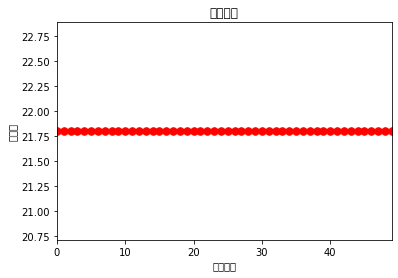

In [20]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pylab as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']


class PSO:
    def __init__(self, dimension, time, size, low, up, v_low, v_high):
        # 初始化
        self.dimension = dimension  # 变量个数
        self.time = time  # 迭代的代数
        self.size = size  # 种群大小
        self.bound = []  # 变量的约束范围
        self.bound.append(low)
        self.bound.append(up)
        self.v_low = v_low
        self.v_high = v_high
        self.x = np.zeros((self.size, self.dimension))  # 所有粒子的位置
        self.v = np.zeros((self.size, self.dimension))  # 所有粒子的速度
        self.p_best = np.zeros((self.size, self.dimension))  # 每个粒子最优的位置
        self.g_best = np.zeros((1, self.dimension))[0]  # 全局最优的位置

        # 初始化第0代初始全局最优解
        temp = -1000000
        for i in range(self.size):
            for j in range(self.dimension):
                self.x[i][j] = random.uniform(self.bound[0][j], self.bound[1][j])
                self.v[i][j] = random.uniform(self.v_low, self.v_high)
            self.p_best[i] = self.x[i]  # 储存最优的个体
            fit = self.fitness(self.p_best[i])
            # 做出修改
            if fit > temp:
                self.g_best = self.p_best[i]
                temp = fit

    def fitness(self, x):
        """
        个体适应值计算
        """
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        rule_query = create_sparse_rule_query(rule)
        group_target = test_data.query(rule_query)
        group_compare = test_data.drop(group_target.index)
        result = rec_fairness_metrics(group_target,group_compare)
        metric_result = result.get_all_unfairness_metrics()
        # print(y)
        return y

    def update(self, size):
        c1 = 2.0  # 学习因子
        c2 = 2.0
        w = 0.8  # 自身权重因子
        for i in range(size):
            # 更新速度
            self.v[i] = w * self.v[i] + c1 * random.uniform(0, 1) * (
                    self.p_best[i] - self.x[i]) + c2 * random.uniform(0, 1) * (self.g_best - self.x[i])
            # 速度限制
            for j in range(self.dimension):
                if self.v[i][j] < self.v_low:
                    self.v[i][j] = self.v_low
                if self.v[i][j] > self.v_high:
                    self.v[i][j] = self.v_high

            # 更新位置
            self.x[i] = list(map(int,self.x[i] + self.v[i]))
            # 位置限制
            for j in range(self.dimension):
                if self.x[i][j] < self.bound[0][j]:
                    self.x[i][j] = self.bound[0][j]
                if self.x[i][j] > self.bound[1][j]:
                    self.x[i][j] = self.bound[1][j]
            # 更新p_best和g_best
            if self.fitness(self.x[i]) > self.fitness(self.p_best[i]):
                self.p_best[i] = self.x[i]
            if self.fitness(self.x[i]) > self.fitness(self.g_best):
                self.g_best = self.x[i]

    def pso(self):
        best = []
        self.final_best = np.array([1, 2, 3])
        for gen in range(self.time):
            self.update(self.size)
            if self.fitness(self.g_best) > self.fitness(self.final_best):
                self.final_best = self.g_best.copy()
            print('当前最佳位置：{}'.format(self.final_best))
            temp = self.fitness(self.final_best)
            print('当前的最佳适应度：{}'.format(temp))
            best.append(temp)
        t = [i for i in range(self.time)]
        plt.figure()
        plt.plot(t, best, color='red', marker='.', ms=15)
        plt.rcParams['axes.unicode_minus'] = False
        plt.margins(0)
        plt.xlabel(u"迭代次数")  # X轴标签
        plt.ylabel(u"适应度")  # Y轴标签
        plt.title(u"迭代过程")  # 标题
        plt.show()


if __name__ == '__main__':
    time = 50
    size = 50
    dimension = 3
    v_low = -1
    v_high = 1
    low = [0, 0, 0]
    up = [1, 6, 20]
    pso = PSO(dimension, time, size, low, up, v_low, v_high)
    pso.pso()
